# 1. Setting Up the Environment  

Initially, we import the essential libraries, each with its own alias:  

- **pandas** – For storing and manipulating tick data.  
- **numpy** – For numerical computations and efficient data handling.  
- **matplotlib** – To visualize extremes and directional changes in tick data.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Loading and storing the data

The tick data CSV files for each currency pair over specific periods have been locally saved. Once loaded, they are stored in a dataframe with a suitable structure for organizing the components of each entry.

If the rightmost column consists entirely of zeros, it is dropped. Additionally, date values, initially stored as strings, must be converted to **datetime** format. Since standard datetime formats only provide second-level accuracy, modifications are necessary to incorporate millisecond precision for the tick data. Moreover, the index of the dataframe is set to datetime.



In [22]:
df = pd.read_csv("C:\\Users\\parsa\\OneDrive\\Desktop\\exchange_data\\GBP-USD\\jan_2025.csv", names=["bid", "ask", "label"])
# importing the data from the local file with corresponding headers.
df.index = pd.to_datetime(df.index, format = "%Y%m%d %H%M%S%f")
# adding a float after seconds in the format of datetime to capture milliseconds.
# Once converted, it is used as the indices in the datetime, whereas before it was the 
# string version of datetime
if((df["label"]!=0).sum()==0):
    del df["label"]
# only delete if all of the entries have 0 for label
df.head()

,bid,ask
2025-01-01 17:01:23.324,1.25134,1.25240
2025-01-01 17:01:34.857,1.25134,1.25236
2025-01-01 17:01:38.819,1.25138,1.25236
2025-01-01 17:02:05.545,1.25136,1.25236
2025-01-01 17:04:20.239,1.25136,1.25236


# 3. Adding midprices to the dataframe:

The **midprice** is calculated at each timestep using the following formula:
$$
\text{midprice} = \frac{\text{bid} + \text{ask}}{2}
$$

Midprices are calculated for each timestep and added as a new column to the dataframe. This value will be used for the detection of extremes and directional changes in the price.  

In [24]:
df["mid"] = (df["bid"]+df["ask"])/2
# new column created and concatenated to the data frame that we had before.
tickdata = df.sort_index(ascending=True)
# As a safety check, the data should be verified to ensure it is in chronological order. This means that the entries should progress
# sequentially from the first recorded price of the month to the last.
tickdata.head()

,bid,ask,mid
2025-01-01 17:01:23.324,1.25134,1.25240,1.25187
2025-01-01 17:01:34.857,1.25134,1.25236,1.25185
2025-01-01 17:01:38.819,1.25138,1.25236,1.25187
2025-01-01 17:02:05.545,1.25136,1.25236,1.25186
2025-01-01 17:04:20.239,1.25136,1.25236,1.25186


# 4. Employing Trading Strategies:
There are two distinct trading strategies, with one being an advancement of the other. Both strategies are expansions of the one covered in **Lab 8**.  
Through parameter optimization and applying these strategies to historical tick data for this currency pair, it was concluded that the coefficient used should be increased from **1/2** to **0.7**. This adjustment generally leads to increased profitability. To clarify, a comparison between the Lab 8's formula and this strategy is drawn:

## 4.1. Steps in Lab 8's strategy:

### long positions:
1. **Open long position** at
$$
\text{DC}^{\uparrow}(\theta)
$$
2. **Take profit**: Close position when  
$$ 
\text{PC} \geq \text{PDCC}^{\uparrow} \times \left(1 + \frac{3}{2}\times {\theta}\right) 
$$  

3. **Stop loss**: Close position when  
$$ 
\text{PC} \leq \text{PDCC}^{\uparrow} \times \left(1 - \frac{3}{2}\times {\theta}\right)
$$

## 4.2 Steps in trading strategy 1:

### *4.2.1. long positions:*
1. **Open long position** at
$$
\text{DC}^{\uparrow}(\theta)
$$
2. **Take profit**: Close position when  
$$ 
\text{PC} \geq \text{PDCC}^{\uparrow} \times \left(1 + 0.7 \times {\theta}\right) 
$$  

3. **Stop loss**: Close position when  
$$ 
\text{PC} \leq \text{PDCC}^{\uparrow} \times \left(1 - 0.7 \times {\theta}\right)
$$

### *4.2.2. short positions:* 

1. **Open short position** at
$$
\text{DC}^{\downarrow}(\theta)
$$
2. **Take profit**: Close position when  
$$ 
\text{PC} \leq \text{PDCC}^{\downarrow} \times \left(1 - 0.7 \times {\theta}\right) 
$$  

3. **Stop loss**: Close position when
$$ 
\text{PC} \geq \text{PDCC}^{\downarrow} \times \left(1 + 0.7 \times {\theta}\right)
$$

### *4.2.3. Modifications to strategy:*


In this strategy, two major changes have been introduced compared to the original strategy:

1. **Opening short positions**: In addition to long positions, short positions will now be opened at the directional changes that indicate the prices are expected to decrease from this point onward. The goal is to profit from a price drop by selling at the current price and then buying it back at a lower price in the future.

2. **Adjustment of the coefficient**: The coefficient of $\theta $, also known as the **threshold factor**, has been updated from **0.5** to **0.7**. This change was based on the results of multiple backtests using historical data, which helped identify the coefficient that resulted in the highest profit or the least loss.

It is important to note that at each timestep, the algorithm only allows for **one long position** and **one short position** to be open at any given time. As a result, there may be instances where no trade is executed during certain directional changes.

### *4.2.4. Pseudocode for Intrinsic Time-Based Trading Strategy*

```plaintext
# Initialize parameters
threshold_factor ← predefined percentage change for directional change
current_direction ← None  # Direction of price movement (Up or Down)
max_ext ← None  # Last recorded local maximum
min_ext ← None  # Last recorded local minimum
IE_points ← empty list  # Stores Intrinsic Events (DCs, Extremes, Further DCs)
positions ← empty list  # Stores opened and closed positions
assigner ← 0  # Index for storing points

# Step 1: Identify the First Directional Change and Open Positions
for tick in tickdata:
    if max_ext is None or min_ext is None:
        max_ext ← tick
        min_ext ← tick
        continue

    # Update max and min at each timestep
    if tick.price > max_ext.price:
        max_ext ← tick
    if tick.price < min_ext.price:
        min_ext ← tick

    if tick.price >= max_ext.price * (1 + threshold_factor):
        current_direction ← "Up"
        IE_points[assigner] ← {max_ext, "EXT"}  # Store the local max as an extreme
        assigner += 1
        IE_points[assigner] ← {tick, "DC"}  # Store the first directional change
        assigner += 1
        open_long_position()
        break

    elif tick.price <= min_ext.price * (1 - threshold_factor):
        current_direction ← "Down"
        IE_points[assigner] ← {min_ext, "EXT"}  # Store the local min as an extreme
        assigner += 1
        IE_points[assigner] ← {tick, "DC"}  # Store the first directional change
        assigner += 1
        open_short_position()
        break

# Step 2: Process Remaining Data for Directional Changes and Intrinsic Events
for tick in tickdata[starting_from_DC:]:
    # Update max and min at each timestep
    if tick.price > max_ext.price:
        max_ext ← tick
    if tick.price < min_ext.price:
        min_ext ← tick

    if current_direction == "Up":
        if tick.price < max_ext.price * (1 - threshold_factor):
            # Downward directional change detected
            IE_points[assigner] ← {max_ext, "EXT"}  # Store the last local max
            assigner += 1
            IE_points[assigner] ← {tick, "DC"}  # Store the directional change
            assigner += 1

            # Update direction and start tracking new minimum
            current_direction ← "Down"
            min_ext ← tick
            open_short_position()

        elif tick.price > last_DC.price * (1 + threshold_factor):
            IE_points[assigner] ← {tick, "F-DC"}  # Further directional change
            assigner += 1
            open_long_position()

        # Manage active long positions
        if long_position_active:
            if tick.bid ≤ stop_loss_long or tick.bid ≥ take_profit_long:
                close_long_position()

    elif current_direction == "Down":
        if tick.price > min_ext.price * (1 + threshold_factor):
            # Upward directional change detected
            IE_points[assigner] ← {min_ext, "EXT"}  # Store the last local min
            assigner += 1
            IE_points[assigner] ← {tick, "DC"}  # Store the directional change
            assigner += 1

            # Update direction and start tracking new maximum
            current_direction ← "Up"
            max_ext ← tick
            open_long_position()

        elif tick.price < last_DC.price * (1 - threshold_factor):
            IE_points[assigner] ← {tick, "F-DC"}  # Further directional change
            assigner += 1
            open_short_position()

        # Manage active short positions
        if short_position_active:
            if tick.ask ≥ stop_loss_short or tick.ask ≤ take_profit_short:
                close_short_position()

# Step 3: Save all intrinsic events and positions to an output file
save_to_excel(IE_points, positions)


In [26]:
""" defining the global variables to use later in trading"""
short_active = False; long_active = False
# initially, no positions are open
profit = 0
# profit is initially 0
open_price_short = None; open_price_long = None
close_price_short = None; close_price_long = None
# the opening and closing prices for our trades
profitable_trades = 0
# number of trades that resulted in profit 
loss_trades = 0
# number of trades that resulted in loss 
coef = 0.7

SL_short = None ; TP_short = None
# The stoploss and take profit for short positions (changes when a new short is opened)
SL_long = None ; TP_long = None
# The stoploss and take profit for long positions (changes when a new long is opened)

strategy_overview = pd.DataFrame(columns=["date-time","bid", "ask", "mid", "type","action"])
# A DataFrame that stores every single position that is opened and closed,  
# along with the corresponding time, bid, and ask prices at those moments.  
#  
# The 'type' column indicates whether the event is a directional change  
# (which leads to opening a position, as indicated in 'action')  
# or whether it corresponds to closing a position, in which case  
# 'type' will store the profit or loss amount for that specific trade.  


# to open a long position
def long_position():
    global long_active, open_price_long, coef, threshold_factor, SL_long, TP_long  # Declare the variables as global
    if long_active == False:  # only allowed if there are no other long positions active
        long_active = True  # position is active now
        open_price_long = IE_points.iloc[-1]  # this will fetch the most recent directional change, which we are currently at, and store it in opening price
        print("long at "+ str(open_price_long["ask"])) # print how much we bought the asset for now

        TP_long = (1+coef*threshold_factor)*open_price_long["ask"] # take profit is calculated using the formula above
        SL_long = (1-coef*threshold_factor)*open_price_long["ask"] # stop loss is calculated using the formula above
 
        length = len(strategy_overview) #gets the number of positions we have had so far
        strategy_overview.loc[length] = open_price_long # the current timestep which is a directional is added to the positions opened
        strategy_overview.loc[length,"action"] = "open long" # the type of the position is set to long
        strategy_overview.loc[length,"type"] = "DC UP" # the position is opened when we have an upwards directional change
        

# to close a long position
def close_long(current_timestep):
    global long_active, open_price_long, close_price_long, loss_trades, profitable_trades, profit  # Declare the variables as global
    if long_active: # only close long if there is one active
        long_active = False # deactivate the position, i.e cashout
        close_price_long = current_timestep #closing price is the current price of the exchanged pair
        trade_profit = (close_price_long["bid"] - open_price_long["ask"]) #the profit is the difference between the ask now 
        # and bid when position was opened
        profit += trade_profit
        # this trades profit is added to overall profit
        print("close long at " + str(close_price_long["bid"]) + " profit: "+ str(trade_profit))
        
        length = len(strategy_overview)
        strategy_overview.loc[length] = close_price_long
        strategy_overview.loc[length,"date-time"] = close_price_long.name
        strategy_overview.loc[length,"action"] = "close long"
        strategy_overview.loc[length,"type"] = str(trade_profit)
        #the details of the current timestep in which we took the action of closing this long position and the profit this 
        #postion has made is stored in the dataframe of all the positions so far.

        if(trade_profit<=0):
            loss_trades += 1
            #if lost money, number of bad trades gets incremented by 1
        else:
            profitable_trades += 1
            #if made money, number of profiable trades gets incremented by 1
    
#to open a short position
def short_position():
    global short_active, profit, open_price_short, close_price_short , coef, SL_short, TP_short, threshold_factor
    if(short_active == False):
        short_active = True # only allowed if there are no other short positions active
        open_price_short = IE_points.iloc[-1]  # this will fetch the most recent directional change, which we are currently at, stores it in opening-price
        print("short at "+ str(open_price_short["bid"]))

        SL_short = open_price_short["bid"]*(1 + coef * threshold_factor) # compute Stop Loss for this position using the formula
        TP_short = open_price_short["bid"]*(1 - coef * threshold_factor) # computes Take profit for this position using the formula
        
        length = len(strategy_overview)#gets the number of positions we have had so far
        strategy_overview.loc[length] = open_price_short # the current timestep which is a directional is added to the positions opened
        strategy_overview.loc[length,"action"] = "open short" # the type of the position is set to short
        strategy_overview.loc[length,"type"] = "DC DOWN" # the position is opened when we have an downwards directional change        

# to close a short position
def close_short(current_timestep):
    global short_active, profit, open_price_short, close_price_short,  loss_trades, profitable_trades, profit  # Declare the variables as global
    if short_active: # only close a short if there is one active
        short_active = False # then set the existence of an active short position to false
        close_price_short = current_timestep # the current timestep is when we close the short position
        trade_profit = (open_price_short["bid"] - close_price_short["ask"]) # the profit is calculated by the open positions ask subtracted from closes bid
        profit += trade_profit # the profit of this trade is added to the net profit so far
        
        print("close short at " + str(close_price_short["ask"]) + " profit: "+ str(trade_profit))
        
        length = len(strategy_overview)
        strategy_overview.loc[length] = close_price_short
        strategy_overview.loc[length,"date-time"] = close_price_short.name
        strategy_overview.loc[length,"action"] = "close short"
        strategy_overview.loc[length,"type"] = str(trade_profit)
        # the details of the current timestep in which we took the action of closing this short position and the profit this 
        # postion has made is stored in the dataframe of all the positions we have opened so far.
        if(trade_profit<0):
            loss_trades += 1
            #if lost money, number of bad trades gets incremented by 1
        else:
            profitable_trades += 1
            #if made money, number of profiable trades gets incremented by 1
        
      

## 4.3 Trading Strategy with Dynamic Stop-Loss and Take-Profit  

This trading strategy is essentially **Trading Strategy 1**, but with the addition of the **Dynamic Stop-Loss and Take-Profit Strategy**. This means that both the stop-loss and take-profit levels adapt dynamically based on the current price movement.  

#### How It Works  
Once a position is opened with an initial stop-loss and take-profit, these levels are adjusted as the price moves in the expected direction.  

#### **For a Long Position**  
- Every time the **current bid price** increases to:  
  $$ (1 - \text{coef} \times \frac{1}{2} \times \text{threshold factor}) \times TP_{\text{long}} $$  
  The stop-loss and take-profit are updated as follows:  
  - **Stop-Loss**:  
    $$ SL_{\text{long}} = \text{current ask} \times \left(1 - \frac{19}{20} \times \text{coef} \times \theta \right) $$  
  - **Take-Profit**:  
    $$ TP_{\text{long}} = \text{current ask} \times \left(1 + \frac{1}{20} \times \text{coef} \times \theta \right) $$  

#### **For a Short Position**  
- Every time the **current ask price** drops below:  
  $$ (1 + \text{coef} \times \frac{1}{2} \times \theta) \times TP_{\text{short}} $$  
  the take-profit and stop-loss are adjusted as follows:  
  - **Take-Profit**:  
    $$ TP_{\text{short}} = \text{current bid} \times \left(1 - \frac{1}{20} \times \text{coef} \times \theta \right) $$  
  - **Stop-Loss**:  
    $$ SL_{\text{short}} = \text{current bid} \times \left(1 + \frac{19}{20} \times \text{coef} \times \theta \right) $$  

This ensures that as the price moves favorably, the **stop-loss follows** to lock in profits, while the **take-profit extends** to capture larger potential gains.

### <span style="color:red">*THE NEXT CODE BLOCK IS AN EXTENSION TO THE PREVIOUS TRADING STRATEGY, WHICH MAKES THE ALGORITHM HAVE DYNAMIC SL AND TP. COMMENT OUT TO EXECUTE THE BASE TRADING STRATEGY. </span>.*

## Trading Strategy 2 pseudocode:
### Initialize parameters
    threshold_factor ← predefined percentage change for directional change
    current_direction ← None  # Direction of price movement (Up or Down)
    max_ext ← None  # Last recorded local maximum
    min_ext ← None  # Last recorded local minimum
    IE_points ← empty list  # Stores Intrinsic Events (DCs, Extremes, Further DCs)
    positions ← empty list  # Stores opened and closed positions
    assigner ← 0  # Index for storing points
    coef ← coefficient for stop-loss and take-profit adjustment
    theta ← predefined threshold factor for dynamic adjustment

### Step 1: Identify the First Directional Change and Open Positions
for tick in tickdata:
    if max_ext is None or min_ext is None:
        max_ext ← tick
        min_ext ← tick
        continue

    # Update max and min at each timestep
    if tick.price > max_ext.price:
        max_ext ← tick
    if tick.price < min_ext.price:
        min_ext ← tick

    # Check for the first directional change
    if tick.price >= max_ext.price * (1 + threshold_factor):
        current_direction ← "Up"
        IE_points[assigner] ← {max_ext, "EXT"}  # Store the local max as an extreme
        assigner += 1
        IE_points[assigner] ← {tick, "DC"}  # Store the first directional change
        assigner += 1
        open_long_position()  # Open a long position when directional change is found
        break

    elif tick.price <= min_ext.price * (1 - threshold_factor):
        current_direction ← "Down"
        IE_points[assigner] ← {min_ext, "EXT"}  # Store the local min as an extreme
        assigner += 1
        IE_points[assigner] ← {tick, "DC"}  # Store the first directional change
        assigner += 1
        open_short_position()  # Open a short position when directional change is found
        break

### Step 2: Process Remaining Data for Directional Changes and Intrinsic Events
for tick in tickdata[starting_from_DC:]:
    # Update max and min at each timestep
    if tick.price > max_ext.price:
        max_ext ← tick
    if tick.price < min_ext.price:
        min_ext ← tick

    # Process the directional changes
    if current_direction == "Up":
        if tick.price < max_ext.price * (1 - threshold_factor):  # Downward directional change detected
            IE_points[assigner] ← {max_ext, "EXT"}  # Store the last local max
            assigner += 1
            IE_points[assigner] ← {tick, "DC"}  # Store the directional change
            assigner += 1
            # Update direction and start tracking new minimum
            current_direction ← "Down"
            min_ext ← tick
            open_short_position()

        elif tick.price > last_DC.price * (1 + threshold_factor):
            IE_points[assigner] ← {tick, "F-DC"}  # Further directional change
            assigner += 1
            open_long_position()  # Open a new long position

        # Adjust stop-loss and take-profit for the long position
        if long_position_active:
            if tick.bid ≤ stop_loss_long or tick.bid ≥ take_profit_long:
                close_long_position()  # Close position if SL or TP is reached
            else:
                # Adjust SL and TP based on market conditions
                if tick.bid >= (1 - coef * (1/2) * threshold_factor) * TP_long:
                    stop_loss_long = tick.ask * (1 - (19/20) * coef * theta)
                    take_profit_long = tick.ask * (1 + (1/20) * coef * theta)

    elif current_direction == "Down":
        if tick.price > min_ext.price * (1 + threshold_factor):  # Upward directional change detected
            IE_points[assigner] ← {min_ext, "EXT"}  # Store the last local min
            assigner += 1
            IE_points[assigner] ← {tick, "DC"}  # Store the directional change
            assigner += 1
            # Update direction and start tracking new maximum
            current_direction ← "Up"
            max_ext ← tick
            open_long_position()

        elif tick.price < last_DC.price * (1 - threshold_factor):
            IE_points[assigner] ← {tick, "F-DC"}  # Further directional change
            assigner += 1
            open_short_position()  # Open a new short position

        # Adjust stop-loss and take-profit for the short position
        if short_position_active:
            if tick.ask ≥ stop_loss_short or tick.ask ≤ take_profit_short:
                close_short_position()  # Close position if SL or TP is reached
            else:
                # Adjust SL and TP based on market conditions
                if tick.ask <= (1 + coef * (1/2) * theta) * TP_short:
                    stop_loss_short = tick.bid * (1 + (19/20) * coef * theta)
                    take_profit_short = tick.bid * (1 - (1/20) * coef * theta)

### Step 3: Save all intrinsic events and positions to an output file
save_to_excel(IE_points, positions)


In [28]:
# if the price goes below the price point mentioned above, the adjust short is called
# This method is used to change the SL and TP of a short position
def adjust_short(current_timestep):
    global SL_short,TP_short, open_price_short,threshold_factor
    if short_active: # only when there is a short position active
        """uncomment the print statements to see the changes to the TP and SL"""
        #print("current SL:"+str(SL_short) + " and TP : "+ str(TP_short)) # the previous TP and SL for the short position
        SL_short = current_timestep["bid"]*(1+(19/20)*coef*threshold_factor) # calculate the new SL for the short positon
        TP_short = current_timestep["bid"]*(1-(1/20)*coef*threshold_factor) # calculate the new TP for the short positon
        #print("changed  SL:"+str(SL_short) + " and TP : "+ str(TP_short)) # the new TP and SL for the short position


# if the price goes above the price point mentioned above, the adjust long is called
# This method is used to change the SL and TP of a short position
def adjust_long(current_timestep):
    global SL_long,TP_long, open_price_long,threshold_factor
    if long_active: # only when there is a short position active
        """uncomment the print statements to see the changes to the TP and SL"""
        #print("current SL:"+str(SL_long) + " and TP : "+ str(TP_long)) # the previous TP and SL for the long position
        SL_long = current_timestep["ask"]*(1-(19/20)*coef*threshold_factor)  # calculate the new SL for the long positon
        TP_long = current_timestep["ask"]*(1+(1/20)*coef*threshold_factor)  # calculate the new TP for the long positon
        #print("changed  SL:"+str(SL_long) + " and TP : "+ str(TP_long)) # the new TP and SL for the long position


# 5. Identifying the First Directional Change  

Finding the **first directional change** is slightly more complex than identifying subsequent ones. This is because we must track both the **moving maximum** and **moving minimum** to determine whether the initial directional change is **upward** or **downward** from the current state.  

However, once the **first directional change** is identified, subsequent directional changes follow a **predictable alternating pattern**:  

- If the **previous directional change** was **downward to upward**, then the next step is to find the **maximum** after the **directional change (DC) point**.  
- This maximum determines the next **DC**, which marks the transition from an **upward movement to a downward movement**.  

By continuously alternating between tracking **local maxima** and **local minima**, we can systematically identify each directional change in the time series.


The **threshold** $ \theta $ is set to a **0.1% price change** to define a significant directional change in the **AUD/USD** currency pair.  

#### **Rationale Behind This Choice**  
- **Market Sensitivity**: In forex trading, small fluctuations in price are common. A 0.1% change represents a meaningful move that is less likely to be just noise but still frequent enough to capture genuine market trends.  
- **AUD/USD Volatility**: The AUD/USD pair is known for its moderate volatility. A 0.1% threshold is **large enough to indicate a shift in market sentiment** but **small enough to detect directional changes early**, allowing for timely trade execution.  
- **Balance Between Responsiveness and Stability**: Setting $ \theta$ too low could lead to frequent false signals (whipsawing), while a higher value might delay reactions to real trend shifts. A 0.1% threshold strikes a balance between **avoiding unnecessary trades** and **capturing genuine price reversals**.  

This threshold ensures that our strategy identifies **significant directional changes** while filtering out **minor price fluctuations** that do not meaningfully impact trading decisions.  


In [30]:
# The first point in other words to draw the analogy the price at this moment is set as the local extreme. 
# (since we have not encountered future prices yet)
min_ext = max_ext = tickdata.iloc[0]
# unsure about the first direction of the price
IE_points = pd.DataFrame(columns=["date-time","bid", "ask", "mid", "type"])
# Dataframe created to store the local extremes and directional change points 
counter = 0 
# used to iterate through the data
assigner = 0
# used as the 1 + final index in the IE_points, used to add new points to intrinsic time.
threshold_factor = 0.001
upwards_movement = None
# if true means moving upwards, if false means downwards trend, currently it's neither.


# while loop to only determine the first directional change, whether it is an upwards trend or a downwards.
while (len(IE_points) == 0 and counter < len(tickdata)):
    # we search till we find the first intrinsic point i.e, or run out of the whole month's data, 
    # (no DCs the whole month, which is extremely unlikely) for this value of theta
    current_tick = tickdata.iloc[counter]
    # current tick is the tick data at the index of the counter

    # If the price is higher than the limit we set, then an upwards DC is detected
    if(min_ext["mid"] * (threshold_factor + 1) < current_tick["mid"]):
        
        IE_points.loc[assigner] = min_ext
        IE_points.loc[assigner,"type"] = "EXT"
        IE_points.loc[assigner,"date-time"] = min_ext.name
        # the local extreme, minimum in this case and the quotes at its timestep
        # are stored in the data from with the type of EXT
        assigner+=1
        # The index is incremented
        
        IE_points.loc[assigner] = current_tick
        IE_points.loc[assigner, "type"] = "DC"
        IE_points.loc[assigner,"date-time"] = current_tick.name
        # The current timestep and its details whose value exceeded the limit for
        # Upwards movement is stored in the dataframe 
        assigner += 1
        # increment to the next available spot, since this one is assigned
        upwards_movement = True
        # The direction of the price trend is now set to upwards.
        max_ext = current_tick
        # Now the local extreme is the current_tick, and we start searching for a new maximum. 
        long_position()
        # open a long position, since the direction is going upwards.
        

     # If the current price is lower than the limit we set, then a downward DC is detected
    elif (max_ext["mid"] * (1 - threshold_factor) > current_tick["mid"]):
        IE_points.loc[assigner] = max_ext
        IE_points.loc[assigner, "type"] = "EXT"
        IE_points.loc[assigner,"date-time"] = max_ext.name
        # the local extreme, maximum in this case and the quotes at its timestep
        # are stored in the data from with the type of EXT
        assigner += 1
        # The index is incremented
        
        IE_points.loc[assigner] = current_tick
        IE_points.loc[assigner, "type"] = "DC"
        IE_points.loc[assigner,"date-time"] = current_tick.name
        # The current timestep and its details, whose value drops below the limit for
        # downwards movement is stored in the dataframe 
        assigner += 1
        # increment to the next available spot, since this one is assigned
        upwards_movement = False
        # The direction of the price trend is now set to downwards.
        min_ext = current_tick
        # Now the local extreme is the current_tick, and we start searching for a new minimum. 
        short_position()
        # open a short position, since the direction is going downwards.
    
    else:    
        if (current_tick["mid"]>max_ext["mid"]): max_ext = current_tick
        # If the current price is higher than the maximum we had, this would be the new maximum
        elif (current_tick["mid"]<min_ext["mid"]): min_ext = current_tick
        # If the current price is lower than the minimum we had, this would be the new minimum
    counter += 1
    # The counter which is used to iterate through the tick data is incremented by one.



long at 1.25207


C:\Users\parsa\AppData\Local\Temp\ipykernel_4696\1511815311.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'EXT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  IE_points.loc[assigner,"type"] = "EXT"
C:\Users\parsa\AppData\Local\Temp\ipykernel_4696\1511815311.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-01-01 18:01:45.070000' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  IE_points.loc[assigner,"date-time"] = min_ext.name


## 6. Capturing the Rest of the Directional Changes  

Once the **first directional change** has been identified, finding subsequent changes follows a structured approach. The key principle is to always look for the **opposite** of the previous directional change:  
- If the last directional change was **upwards**, the next step is to find the **maximum** and identify the next **downwards** change.  
- Conversely, if the last directional change was **downwards**, the focus shifts to finding the **minimum** and the next **upwards** change.  

### Identifying Further Directional Changes  

As discussed in **Slide 44 of Week 8’s content**, the algorithm also detects **further directional changes**, which I have explicitly labeled. These points arise in **two specific scenarios**:  

#### 1. Upwards Continuation  
- The previous directional change was **upwards**.  
- The price then exceeds:  
  $$ (1 + \theta) \times PDCC^{\uparrow}[\text{mid}] $$  
- This confirms that the upward trend continues, marking it as a **further directional change**.  

#### 2. Downwards Continuation  
- The previous directional change was **downwards**.  
- The price then falls below:  
  $$ (1 - \theta) \times PDDC^{\downarrow}[\text{mid}] $$  
- This confirms a continued downward movement, marking it as a **further directional change**.  

Both these points are also saved as **intrinsic points** where the algorithm may open a **long or short** position, provided that no active position already exists.  

In [32]:
tickdata = tickdata[current_tick.name:]
# We only look at the tick data from the current directional change onwards, since we have already found the directional change in this period.
current_DC = IE_points.iloc[-1]
# The current directional change variable is set to the last one (DC) discovered 

# A for loop to go through all the tick data 
for timestep in range(0,len(tickdata)):
    current_tick = tickdata.iloc[timestep]
    # the current tick is the new timestep.
    if upwards_movement:
        # only look for the downwards directional change if the direction of the price is currently upwards.
        if max_ext["mid"]*(1-threshold_factor)>current_tick["mid"]:
            IE_points.loc[assigner] = max_ext
            IE_points.loc[assigner, "type"] = "EXT"
            IE_points.loc[assigner,"date-time"] = max_ext.name
            # the local extreme, maximum in this case and the quotes at its timestep
            # are stored in the dataframe with the type of EXT
            assigner += 1
            # The index is incremented
        
            IE_points.loc[assigner] = current_tick
            IE_points.loc[assigner, "type"] = "DC"
            IE_points.loc[assigner,"date-time"] = current_tick.name
            current_DC = IE_points.loc[assigner]
            # The current timestep and its details, whose value drops below the limit for
            # downwards movement is stored in the dataframe 
            assigner += 1
            upwards_movement = False
            # The direction of the price trend is now set to downwards.
            min_ext = current_tick
            # Now the local extreme is the current_tick, and we start searching for a new minimum.
            short_position()
            # open a short position, since the direction is going downwards.
        else:
        # If the direction is upwards, and the current price is larger than the maximum
           if(max_ext["mid"]<current_tick["mid"]):
               max_ext = current_tick # Then this would become the new maximum.
               if(IE_points.iloc[-1]["mid"]*(1+threshold_factor)<max_ext["mid"]):
                   # finding further intrinsic points if the price goes higher than a certain amount upwards, they have the type further directional change
                   IE_points.loc[assigner] = max_ext
                   IE_points.loc[assigner,"date-time"] = max_ext.name
                   IE_points.loc[assigner,"type"] = "F-DC"
                   current_DC = IE_points.loc[assigner]
                   # This point and its timestamp plus the quotes are stored as the further directional change in the intrinsic points dataframe.
                   long_position() # open a long position
                   #further extreme(another max)
                   assigner+=1
       
        if long_active: # if we confirmed the trend that the price is going up, and we have an active long:
            if current_tick["bid"] <= SL_long or  current_tick["bid"] >= TP_long: 
                #if the current bid price is smaller than the stop loss and larger than the take profit, close the long position 
                close_long(current_tick)
            """COMMENT THIS SECTION OUT IF YOU WANT TO RUN THE BASE SHORTING AND LONGING STRATEGY MINUS (NO DYNAMIC SL AND TP CHANGES)"""
            if (current_tick["bid"] >=  (1-coef*(1/2)*threshold_factor) * TP_long):  # if the current bid is lorger than 
                adjust_long(current_tick)                                            # the calculated limit to readjust the long positions SL and TP.
            """--------------------------------------------------------------------------------------------------------------------------"""   
        
                           
            
    elif not upwards_movement:  # only look for the upwards directional change if the direction of the price is currently downwards.
        if(min_ext["mid"] * (threshold_factor + 1) < current_tick["mid"]):
            IE_points.loc[assigner] = min_ext
            IE_points.loc[assigner,"type"] = "EXT"
            IE_points.loc[assigner,"date-time"] = min_ext.name
            assigner+=1
             # the local extreme, minimum in this case and the quotes at its timestep
            # are stored in the data frame with the type of EXT
            # The new position to add intrinsic points is incremented
            
            IE_points.loc[assigner] = current_tick
            IE_points.loc[assigner, "type"] = "DC"
            IE_points.loc[assigner,"date-time"] = current_tick.name
            current_DC = IE_points.loc[assigner]
            assigner += 1
            # The current timestep and its details, whose value drops below the limit for
            # Upwards movement is stored in the dataframe 
            upwards_movement = True
            max_ext = current_tick
            # Now the local extreme is the current_tick, and we start searching for a new maximum.
            long_position()
            # open a long position, since the direction is going upwards.
        else:
             if(min_ext["mid"]>current_tick["mid"]):
            #if the direction is downwards and the current tick value is smaller than the minimum tick so far, assign the new one as the local extreme
               min_ext = current_tick
               if(IE_points.iloc[-1]["mid"]*(1-threshold_factor)>min_ext["mid"]):
                   IE_points.loc[assigner] = min_ext
                   IE_points.loc[assigner,"date-time"] = min_ext.name
                   IE_points.loc[assigner,"type"] = "F-DC"
                   # if the current price goes below a certain amount lower than the previous downwards directional change point
                   # save this as a further directional change alongside its time and information in the intrinsic events data frame.
                   short_position() # open a short position
                   assigner+=1
                   #increment it to be set to the next available spot
                   
        
        if short_active: 
            # If we currently have a short position active, and the 
            # price goes below TP or lower than the SL, close short
            if (current_tick["ask"] <= TP_short or current_tick["ask"] >= SL_short):
                close_short(current_tick)
                """COMMENT THIS SECTION OUT IF YOU WANT TO RUN THE BASE SHORTING AND LONGING STRATEGY MINUS (NO DYNAMIC SL AND TP CHANGES)"""
                
            if(current_tick["ask"]<= (1+coef*(1/2)*threshold_factor) * TP_short): # if the current bid is smaller than 
                adjust_short(current_tick)     # the calculated limit to readjust the short positions SL and TP.                
                """---------------------------------------------------------------------------------------------------------------------"""    
            
    
#I still need to add the double in one direction
IE_points.head()

close long at 1.25119 profit: -0.0008799999999999919
long at 1.25335
short at 1.25276
close short at 1.25188 profit: 0.0008799999999999919
short at 1.25147
close long at 1.25034 profit: -0.003009999999999957
close short at 1.2494 profit: 0.0020700000000000163
long at 1.24996
close long at 1.24908 profit: -0.0008799999999999919
short at 1.249
close short at 1.24761 profit: 0.0013900000000000023
short at 1.24651
close short at 1.24586 profit: 0.0006500000000000394
short at 1.24524
close short at 1.2443 profit: 0.0009399999999999409
short at 1.244
long at 1.24483
close short at 1.24449 profit: -0.0004900000000001015
short at 1.24313
close short at 1.24183 profit: 0.0013000000000000789
short at 1.24059
close short at 1.24019 profit: 0.000400000000000178
close long at 1.24113 profit: -0.0037000000000000366
short at 1.24004
close short at 1.24091 profit: -0.0008699999999999264
long at 1.24018
close long at 1.2393 profit: -0.0008799999999999919
short at 1.23919
close short at 1.24006 profit: 

,date-time,bid,ask,mid,type
0,2025-01-01 18:01:45.070000,1.25060,1.25090,1.250750,EXT
1,2025-01-01 19:00:01.557000,1.25194,1.25207,1.252005,DC
2,2025-01-01 21:56:39.792000,1.25322,1.25335,1.253285,F-DC
3,2025-01-01 23:14:29.884000,1.25400,1.25411,1.254055,EXT
4,2025-01-02 02:04:37.415000,1.25276,1.25284,1.252800,DC


In [33]:
IE_points

,date-time,bid,ask,mid,type
0,2025-01-01 18:01:45.070000,1.25060,1.25090,1.250750,EXT
1,2025-01-01 19:00:01.557000,1.25194,1.25207,1.252005,DC
2,2025-01-01 21:56:39.792000,1.25322,1.25335,1.253285,F-DC
3,2025-01-01 23:14:29.884000,1.25400,1.25411,1.254055,EXT
4,2025-01-02 02:04:37.415000,1.25276,1.25284,1.252800,DC
...,...,...,...,...,...
1861,2025-01-31 16:10:02.043000,1.23940,1.23955,1.239475,DC
1862,2025-01-31 16:13:41.728000,1.23865,1.23879,1.238720,EXT
1863,2025-01-31 16:28:44.783000,1.23992,1.24006,1.239990,DC
1864,2025-01-31 16:33:18.659000,1.24011,1.24027,1.240190,EXT


# 7. StoringPositions, Local Extremes, and Directional Changes

After processing the entire period's data, all **intrinsic points** (directional changes, local extremes, and further directional changes) are saved to an **Excel file** for further analysis.

## Handling Overlapping Points
- In some cases, a **directional change (DC)** may also coincide with a **local extreme (EXT)**.
- Instead of storing these as two separate entries with the **same timestamp and price quotes**, they are **merged** into a single entry.
- The new type is a **concatenation** of their previous types:  
  `DC + EXT`

## Saving Trade Data
- Every **long position** that is opened and its corresponding **closing position** is recorded.
- Each entry includes:
  - **Position type** (e.g., long, short)
  - **Profit or loss** for that specific trade
  - **Timestamps** for open and close

These details are also stored in an **Excel file** to enhance the analysis of every single trade.


In [35]:
IE_TimeSeries = IE_points.groupby(["date-time", "bid", "ask", "mid"], as_index=False).agg({
    "type": " ".join
}).reset_index(drop=True)
# merging the two entries with the same values and concatenating their types.
IE_TimeSeries.to_excel("C:\\Users\\parsa\\OneDrive\\Desktop\\output-refined.xlsx")
# The cleaned-up timeseries is stored in a desktop file
strategy_overview.to_excel("C:\\Users\\parsa\\OneDrive\\Desktop\\positions.xlsx")
# All the positions and their details regarding the opening and closing is also stored in a separate file.

In [36]:
strategy_overview
# a preview of how the positions are stored in an excel file

,date-time,bid,ask,mid,type,action
0,2025-01-01 19:00:01.557000,1.25194,1.25207,1.252005,DC UP,open long
1,2025-01-01 19:14:39.865000,1.25119,1.25134,1.251265,-0.0008799999999999919,close long
2,2025-01-01 21:56:39.792000,1.25322,1.25335,1.253285,DC UP,open long
3,2025-01-02 02:04:37.415000,1.25276,1.25284,1.2528,DC DOWN,open short
4,2025-01-02 03:00:05.570000,1.25185,1.25188,1.251865,0.0008799999999999919,close short
...,...,...,...,...,...,...
1437,2025-01-31 16:07:43.211000,1.24058,1.24074,1.24066,0.000320000000000098,close long
1438,2025-01-31 16:10:02.043000,1.2394,1.23955,1.239475,DC DOWN,open short
1439,2025-01-31 16:28:44.783000,1.23992,1.24006,1.23999,DC UP,open long
1440,2025-01-31 16:38:12.079000,1.23914,1.23925,1.239195,-0.0009200000000000319,close long


In [37]:
IE_TimeSeries
# a preview of local extremes, intrinsic points(directional changes, and further directional changes)

,date-time,bid,ask,mid,type
0,2025-01-01 18:01:45.070,1.25060,1.25090,1.250750,EXT
1,2025-01-01 19:00:01.557,1.25194,1.25207,1.252005,DC
2,2025-01-01 21:56:39.792,1.25322,1.25335,1.253285,F-DC
3,2025-01-01 23:14:29.884,1.25400,1.25411,1.254055,EXT
4,2025-01-02 02:04:37.415,1.25276,1.25284,1.252800,DC
...,...,...,...,...,...
1846,2025-01-31 16:10:02.043,1.23940,1.23955,1.239475,DC
1847,2025-01-31 16:13:41.728,1.23865,1.23879,1.238720,EXT
1848,2025-01-31 16:28:44.783,1.23992,1.24006,1.239990,DC
1849,2025-01-31 16:33:18.659,1.24011,1.24027,1.240190,EXT


# 8. Performance of the Trading Strategy

The performance is assessed using the following metrics:

1. **Win/Loss Ratio**: The ratio of profitable positions to total positions.
2. **Total Profit**: The sum of profits and losses from all trades.

These metrics help evaluate the strategy's effectiveness and guide potential improvements.


In [39]:
print("successful positions: "+ str(profitable_trades) + ", " + "failed postions: " + str(loss_trades) +
      ", net profit:" + str(profit) + ", the win position ratio :" + str(profitable_trades/(loss_trades+profitable_trades)))


successful positions: 324, failed postions: 397, net profit:-0.07419000000000175, the win position ratio :0.44937586685159503


# 9. Plotting the First Intrinsic Points, Directional Changes, and Further Directional Changes

The first 20 intrinsic points, directional changes, and further directional changes are plotted along with the maximum and minimum values. This provides a graphical representation of the key points within the tick data and their extraction.

- **X marks**: Represent the extremes (maximum and minimum values).
- **Circles**: Represent the directional and further directional changes.

This plot helps visualize the key moments in the tick data, allowing us to easily spot significant movements and turning points.


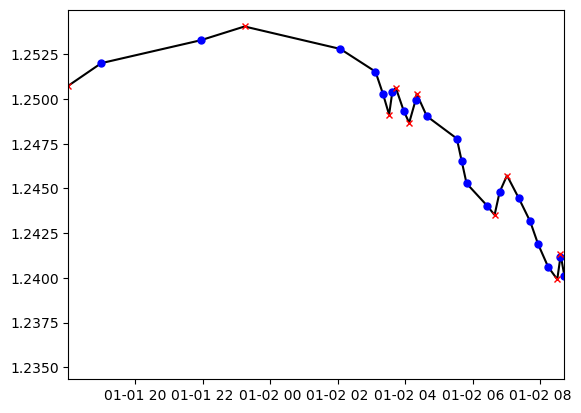

In [41]:
DCS = IE_points[IE_points["type"].isin(["DC", "F-DC"])].iloc[:20]
EXTS = (IE_points[IE_points["type"]=="EXT"]).iloc[:20]
# selecting the first 20 Directional change or further directional change points
# also the first 20 local extremes
combined = pd.concat([DCS, EXTS]).sort_values(by="date-time")
# the two are concatenated 

# Plot a continuous line connecting all points
plt.plot(combined["date-time"], combined["mid"], '-', color='black', label="All Points")

# Plot DCS points as circles ('o')
plt.plot(DCS["date-time"], DCS["mid"], 'o', markersize=5, color='blue', label="DCS")

# Plot EXTS points as crosses ('x')
plt.plot(EXTS["date-time"], EXTS["mid"], 'x', markersize=5, color='red', label="EXTS")

time_min = EXTS["date-time"].min()
time_max = DCS["date-time"].max()
buffer = pd.Timedelta(milliseconds=500) # Adjust this value based on your data frequency

plt.xlim(time_min - buffer, time_max + buffer)
# Readjust the xlim to get the data to fit.

plt.show()

# 10. Limitations and Future Work

There are some limitations in the current strategy that could be addressed for better results:

1. **Single Position Limitation**: The strategy only allows for one long and one short position at a time. Lifting this restriction might lead to better profits, as it would enable multiple positions of the same type to be open simultaneously, offering more trading opportunities.

2. **Fixed Position Size**: Each position is currently opened with a fixed size of one unit. Allowing the strategy to determine the position size based on various factors and market conditions could improve profitability and risk management.

3. **Varying Theta (ATV)**: The threshold factor, θ, is currently constant. Introducing an Adaptive Threshold Volatility (ATV) would allow θ to adjust based on the recent volatility and variability of the market data, enabling the strategy to respond more dynamically to changing market conditions.

4. **Volume Weighted Extremes**: The detection of local extremes, as of now, solely depends on the price. This could be improved by also checking what volume has been traded at that extreme. A larger volume at an extreme could be indicative of an important point in comparison to an extreme with a lower traded volume. You can use weighted volume extremes to confirm directional changes (DC) in your trading strategy. When a price moves significantly (up or down), you check if the volume at that point exceeds a predefined threshold. This helps to ensure that the price move is supported by significant market activity.
